In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## **Fetch of the Kaggle Cats vs Dogs dataset**

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   121M      0  0:00:06  0:00:06 --:--:--  129M


In [4]:
!unzip -q kagglecatsanddogs_3367a.zip

In [5]:
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [6]:
!ls PetImages

Cat  Dog


## **Coding of the convolutional neural network from scratch**

First, let's filter out the corrupted images

In [7]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f'Deleted {num_skipped} images')

Deleted 1590 images


Before testing the model, it is better to do validation at last phase of training. Let's create a dataset of our images with 2% validation datasets and remaining 98% as training datasets.

In [8]:
image_size = (180, 180)
batch_size = 32


In [9]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


Let's visualize the image of your choice. Label 1 is for 'dog' and label 0 is for 'cat'.

In [10]:
import matplotlib.pyplot as plt

In [11]:
def image(i,b):
  plt.figure(figsize=(4, 4))
  for images, labels in train_ds.take(b):
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(int(labels[i]))
      plt.axis("off")

In [12]:
batch = int(input("Enter batch no.: "))

Enter batch no.: 5


In [13]:
idx = int(input("Enter index number: "))

Enter index number: 21


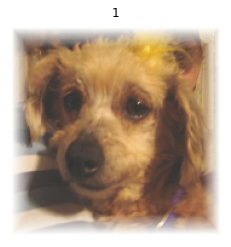

In [14]:
image(idx,batch)

**Data augmentation**

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

Augmented image of first image in the dataset

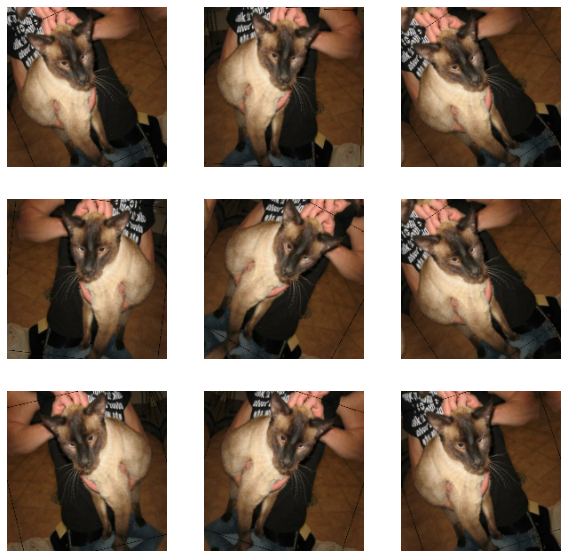

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
      augmented_images = data_augmentation(images)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_images[0].numpy().astype("uint8"))
      plt.axis("off")

Finally lets build a model

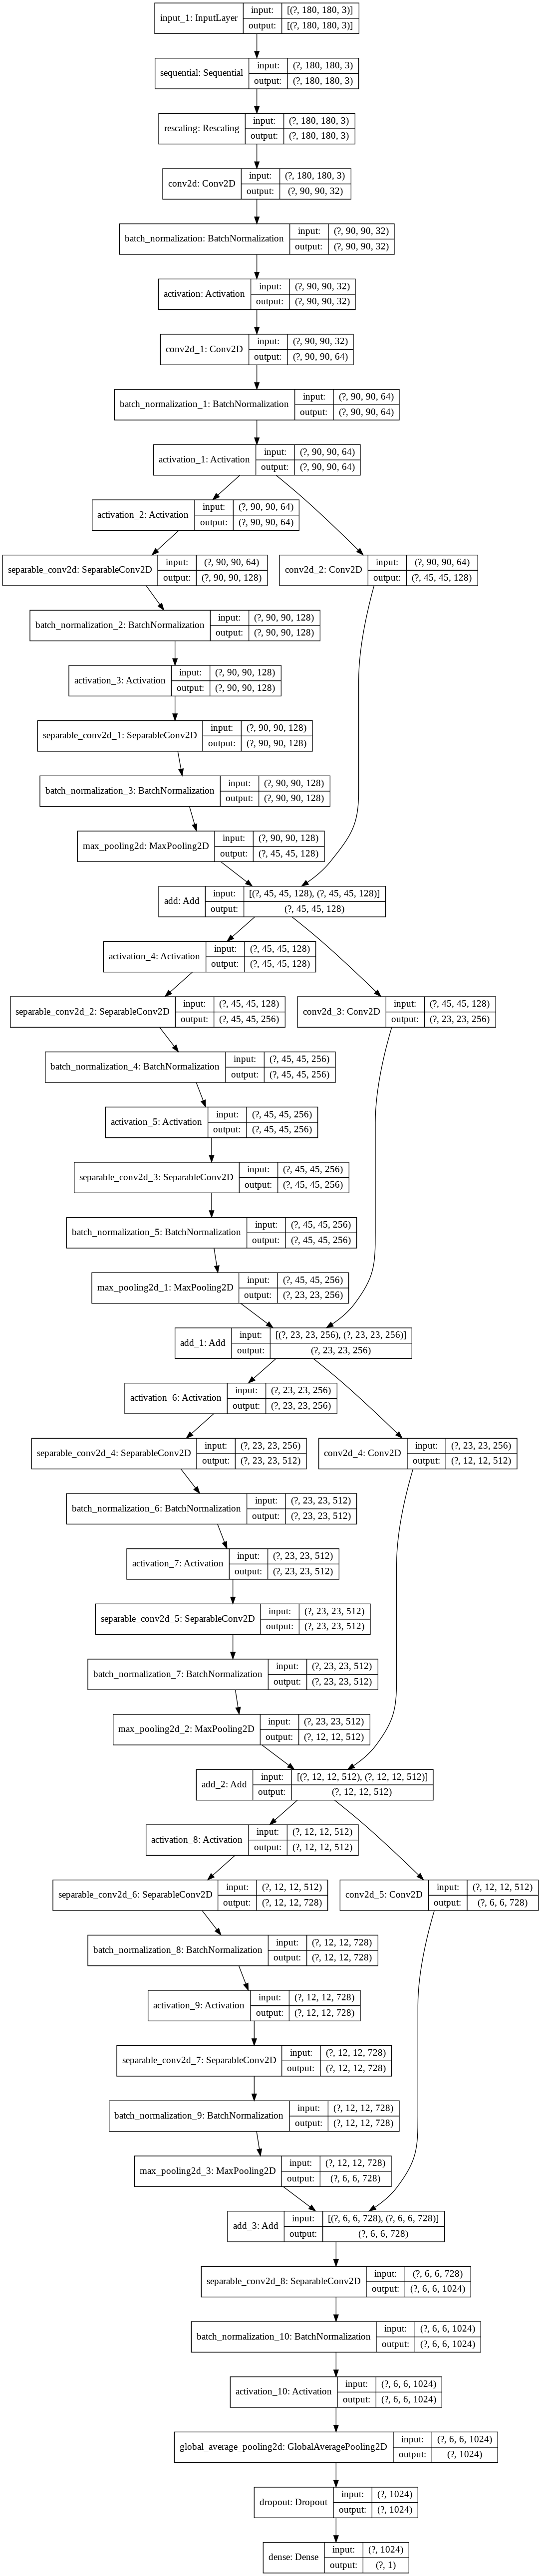

In [17]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

## **Calculation of the accuracy of the model with 25 epochs and then 50 epochs**

In [18]:
import time

In [19]:
def train_model(epochs):
  callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    ]
  model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
  )
  startTime = time.time()
  model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
  )
  endTime = time.time()
  
  print(f'\n It took {(endTime - startTime)/3600} hours for ML training \n')

In [20]:
epochs25 = train_model(25)
epochs25

Epoch 1/25
586/586 [==============================] - 245s 418ms/step - loss: 0.6380 - accuracy: 0.6546 - val_loss: 0.6326 - val_accuracy: 0.6572
Epoch 2/25
586/586 [==============================] - 246s 421ms/step - loss: 0.4994 - accuracy: 0.7621 - val_loss: 0.5441 - val_accuracy: 0.7505
Epoch 3/25
586/586 [==============================] - 248s 423ms/step - loss: 0.4059 - accuracy: 0.8180 - val_loss: 0.4510 - val_accuracy: 0.7911
Epoch 4/25
586/586 [==============================] - 247s 422ms/step - loss: 0.3321 - accuracy: 0.8543 - val_loss: 0.2710 - val_accuracy: 0.8874
Epoch 5/25
586/586 [==============================] - 248s 423ms/step - loss: 0.2708 - accuracy: 0.8846 - val_loss: 0.3055 - val_accuracy: 0.8755
Epoch 6/25
586/586 [==============================] - 246s 420ms/step - loss: 0.2288 - accuracy: 0.9042 - val_loss: 0.5078 - val_accuracy: 0.7969
Epoch 7/25
586/586 [==============================] - 248s 423ms/step - loss: 0.2032 - accuracy: 0.9160 - val_loss: 0.2012 -

In [21]:
epochs50 = train_model(50)
epochs50

Epoch 1/50
586/586 [==============================] - 249s 425ms/step - loss: 0.0892 - accuracy: 0.9643 - val_loss: 0.1256 - val_accuracy: 0.9481
Epoch 2/50
586/586 [==============================] - 248s 422ms/step - loss: 0.0875 - accuracy: 0.9660 - val_loss: 0.1180 - val_accuracy: 0.9549
Epoch 3/50
586/586 [==============================] - 248s 423ms/step - loss: 0.0837 - accuracy: 0.9668 - val_loss: 0.1032 - val_accuracy: 0.9626
Epoch 4/50
586/586 [==============================] - 247s 421ms/step - loss: 0.0812 - accuracy: 0.9672 - val_loss: 0.1057 - val_accuracy: 0.9581
Epoch 5/50
586/586 [==============================] - 247s 422ms/step - loss: 0.0799 - accuracy: 0.9696 - val_loss: 0.0962 - val_accuracy: 0.9631
Epoch 6/50
586/586 [==============================] - 248s 422ms/step - loss: 0.0824 - accuracy: 0.9677 - val_loss: 0.0991 - val_accuracy: 0.9639
Epoch 7/50
586/586 [==============================] - 248s 424ms/step - loss: 0.0754 - accuracy: 0.9691 - val_loss: 0.1035 -

## **Code that prompts the user for an image online**

In [27]:
url = input("Enter url of the image: ")

Enter url of the image: https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Arthur%2C_the_cat.jpg/1280px-Arthur%2C_the_cat.jpg


In [28]:
import urllib.request

urllib.request.urlretrieve(url, "sample.jpg")

('sample.jpg', <http.client.HTTPMessage at 0x7f60e6039dd8>)

In [29]:
# load and resize an image with Pillow
from PIL import Image
# load the image
image = Image.open('sample.jpg')
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# resize image and ignore original aspect ratio
img_resized = image.resize((180,180))
# report the size of the thumbnail
print(img_resized.size)

JPEG
RGB
(1280, 960)
(180, 180)


uint8
(960, 1280, 3)


(-0.5, 1279.5, 959.5, -0.5)

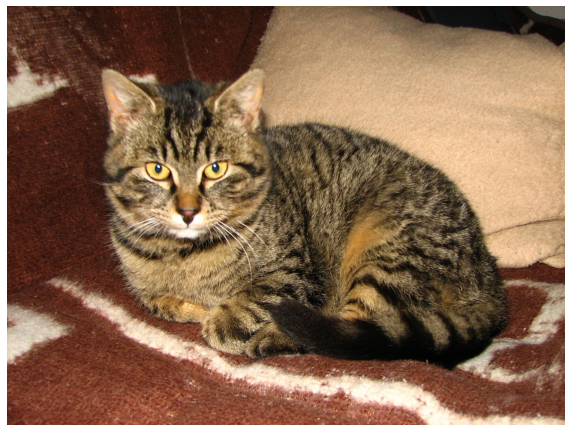

In [30]:
#show an image
from matplotlib import image
# load image as pixel array
data = image.imread('sample.jpg')
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
plt.figure(figsize=(10, 10))
plt.imshow(data)
plt.axis('off')

## **Predictor model in the image from the URL submitted by the user**

In [31]:
img = keras.preprocessing.image.load_img(
    "sample.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
catPercent = float(100 * (1 - score))
dogPercent = float(100 * score)
if score < 0.4:
  print(f'\nThis image is {catPercent:.2f} percent cat and {dogPercent:.2f} percent dog. \nSo, it is definitely a Cat. \n')
elif score<0.5:
  print(f'\nThis image is {catPercent:.2f} percent cat and {dogPercent:.2f} percent dog. \nSo, it may be a Cat. \n')
elif score == 0.5:
  print(f"\nThis image is {catPercent:.2f} percent cat and {dogPercent:.2f} percent dog. \nSo, it can't be determined. \n")
elif score < 0.6:
  print(f'\nThis image is {catPercent:.2f} percent cat and {dogPercent:.2f} percent dog. \nSo, it may be a Dog. \n')
else:
  print(f'\nThis image is {catPercent:.2f} percent cat and {dogPercent:.2f} percent dog. \nSo, it is definitely a Dog. \n')


This image is 100.00 percent cat and 0.00 percent dog. 
So, it is definitely a Cat. 

